In [ ]:
# --------------------------------------------------------------
#  Imports
# --------------------------------------------------------------
import os
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# --------------------------------------------------------------
#  Helper – read a binary‑output file (one 0/1 per line)
# --------------------------------------------------------------
def read_binary_file(filepath: Path) -> np.ndarray:
    """Return a 1‑D numpy array of ints (0/1) from a txt file."""
    with open(filepath, "r") as f:
        data = [int(line.strip()) for line in f if line.strip() != ""]
    return np.asarray(data, dtype=int)


# --------------------------------------------------------------
#  Evaluate ONE prediction folder against the ground‑truth folder
# --------------------------------------------------------------
def evaluate_prediction_set(
    root_dir: Path,
    dataset_name: str,          # "ESADA" or "SIESTA"
    pred_folder: str,           # "hhe_binaryoutput" or "plaintext_binaryoutput"
    gt_folder: str = "baseline_binaryoutput",
) -> pd.DataFrame:
    """
    Returns a DataFrame with one row per file:
        dataset, model, file_id, n_samples,
        accuracy, precision, recall, f1
    """
    pred_dir = root_dir / f"{dataset_name}_4percent" / pred_folder
    gt_dir   = root_dir / f"{dataset_name}_4percent" / gt_folder

    if not pred_dir.is_dir() or not gt_dir.is_dir():
        raise FileNotFoundError(
            f"Missing {pred_folder} or {gt_folder} for {dataset_name}"
        )

    # ----- identifier → file‑path maps ---------------------------------
    # prediction files end with "_hhe_binaryoutput.txt" or "_plaintext_binaryoutput.txt"
    pred_suffix = f"_{pred_folder}"          # e.g. "_hhe_binaryoutput"
    pred_files = {
        p.stem.replace(pred_suffix, ""): p
        for p in pred_dir.glob(f"*{pred_suffix}.txt")
    }

    # ground‑truth files always end with "_binaryoutput.txt"
    gt_suffix = "_binaryoutput"
    gt_files = {
        p.stem.replace(gt_suffix, ""): p
        for p in gt_dir.glob(f"*{gt_suffix}.txt")
    }

    # keep only identifiers that exist in BOTH folders
    common_ids = sorted(set(pred_files) & set(gt_files))

    rows = []
    for fid in tqdm(common_ids,
                    desc=f"{dataset_name} – {pred_folder}",
                    unit="file"):
        y_pred = read_binary_file(pred_files[fid])
        y_true = read_binary_file(gt_files[fid])

        if y_pred.shape[0] != y_true.shape[0]:
            raise ValueError(
                f"Length mismatch in {fid}: {y_pred.shape[0]} vs {y_true.shape[0]}"
            )

        # ---- compute metrics (zero_division=0 avoids warnings) -----
        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)

        rows.append(
            {
                "dataset": dataset_name.lower(),   # esada / siesta
                "model":   pred_folder,            # folder name as model id
                "file_id": fid,
                "n_samples": len(y_true),
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1,
            }
        )
    return pd.DataFrame(rows)


# --------------------------------------------------------------
#  Run the evaluation for both datasets and both models
# --------------------------------------------------------------
ROOT = Path(".")          # change if your data live elsewhere

# ESADA
esada_hhe   = evaluate_prediction_set(ROOT, "ESADA", "hhe_binaryoutput")
esada_plain = evaluate_prediction_set(ROOT, "ESADA", "plaintext_binaryoutput")

# SIESTA
siesta_hhe   = evaluate_prediction_set(ROOT, "SIESTA", "hhe_binaryoutput")
siesta_plain = evaluate_prediction_set(ROOT, "SIESTA", "plaintext_binaryoutput")

# Combine everything into one DataFrame
all_results = pd.concat(
    [esada_hhe, esada_plain, siesta_hhe, siesta_plain],
    ignore_index=True,
)

display(all_results.head())

In [8]:
siesta_hhe.sort_values('f1')

,dataset,model,file_id,n_samples,accuracy,precision,recall,f1
0,siesta,hhe_binaryoutput,c000101,29,0.793103,0.0,0.000000,0.000000
1,siesta,hhe_binaryoutput,c000102,27,0.740741,0.0,0.000000,0.000000
3,siesta,hhe_binaryoutput,c000202,46,0.804348,0.0,0.000000,0.000000
4,siesta,hhe_binaryoutput,c000301,25,0.560000,0.0,0.000000,0.000000
7,siesta,hhe_binaryoutput,c000402,23,0.565217,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
169,siesta,hhe_binaryoutput,m003501,10,0.800000,1.0,0.800000,0.888889
191,siesta,hhe_binaryoutput,ma02702,19,0.894737,1.0,0.833333,0.909091
192,siesta,hhe_binaryoutput,ma02801,15,1.000000,1.0,1.000000,1.000000
250,siesta,hhe_binaryoutput,na01101,97,1.000000,1.0,1.000000,1.000000


In [2]:
# --------------------------------------------------------------
#  Un‑weighted per‑dataset‑per‑model summary (mean ± std)
# --------------------------------------------------------------
def summary_stats(df: pd.DataFrame) -> pd.DataFrame:
    """Mean ± std, grouped by dataset and model (no weighting)."""
    agg = (
        df.groupby(["dataset", "model"])
        .agg(
            n_files=("file_id", "count"),
            accuracy_mean=("accuracy", "mean"),
            accuracy_std=("accuracy", "std"),
            precision_mean=("precision", "mean"),
            precision_std=("precision", "std"),
            recall_mean=("recall", "mean"),
            recall_std=("recall", "std"),
            f1_mean=("f1", "mean"),
            f1_std=("f1", "std"),
        )
        .reset_index()
    )
    return agg


summary = summary_stats(all_results)
display(summary)

# --------------------------------------------------------------
#  Weighted per‑dataset‑per‑model summary (weights = n_samples)
# --------------------------------------------------------------
def summary_stats_weighted(df: pd.DataFrame) -> pd.DataFrame:
    """Weighted mean ± std using file length (`n_samples`) as the weight."""
    def wmean(series, weights):
        return np.average(series, weights=weights)

    def wstd(series, weights):
        m = wmean(series, weights)
        return np.sqrt(np.average((series - m) ** 2, weights=weights))

    rows = []
    for (ds, mdl), sub in df.groupby(["dataset", "model"]):
        w = sub["n_samples"].astype(float).values

        rows.append(
            {
                "dataset": ds,
                "model": mdl,
                "n_files": sub.shape[0],
                "n_samples_total": int(w.sum()),
                "accuracy_wmean": wmean(sub["accuracy"], w),
                "accuracy_wstd":  wstd(sub["accuracy"], w),
                "precision_wmean": wmean(sub["precision"], w),
                "precision_wstd":  wstd(sub["precision"], w),
                "recall_wmean": wmean(sub["recall"], w),
                "recall_wstd":  wstd(sub["recall"], w),
                "f1_wmean": wmean(sub["f1"], w),
                "f1_wstd":  wstd(sub["f1"], w),
            }
        )
    return pd.DataFrame(rows)


weighted_summary = summary_stats_weighted(all_results)
display(weighted_summary)

,dataset,model,n_files,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,esada,hhe_binaryoutput,423,0.786591,0.153262,0.654659,0.386228,0.213520,0.185488,0.303550,0.225507
1,esada,plaintext_binaryoutput,422,0.856757,0.092975,0.706622,0.268734,0.540363,0.248448,0.589058,0.239661
2,siesta,hhe_binaryoutput,399,0.785555,0.187847,0.519887,0.454437,0.154122,0.192072,0.221016,0.238887
3,siesta,plaintext_binaryoutput,398,0.860050,0.123698,0.602892,0.395676,0.405993,0.319790,0.461647,0.332739


,dataset,model,n_files,n_samples_total,accuracy_wmean,accuracy_wstd,precision_wmean,precision_wstd,recall_wmean,recall_wstd,f1_wmean,f1_wstd
0,esada,hhe_binaryoutput,423,27383,0.815689,0.130144,0.612444,0.393205,0.180583,0.157816,0.264348,0.202349
1,esada,plaintext_binaryoutput,422,27382,0.866482,0.083737,0.677109,0.271835,0.505627,0.241389,0.553910,0.233426
2,siesta,hhe_binaryoutput,399,24918,0.822939,0.165042,0.489660,0.447302,0.134083,0.172176,0.196476,0.218673
3,siesta,plaintext_binaryoutput,398,24917,0.877353,0.108832,0.562884,0.394384,0.375772,0.311108,0.426259,0.324598


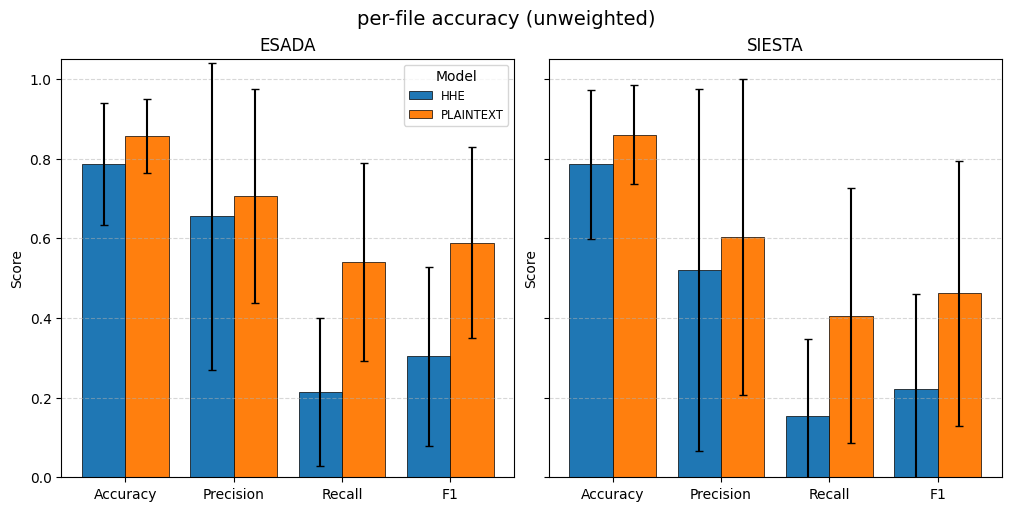

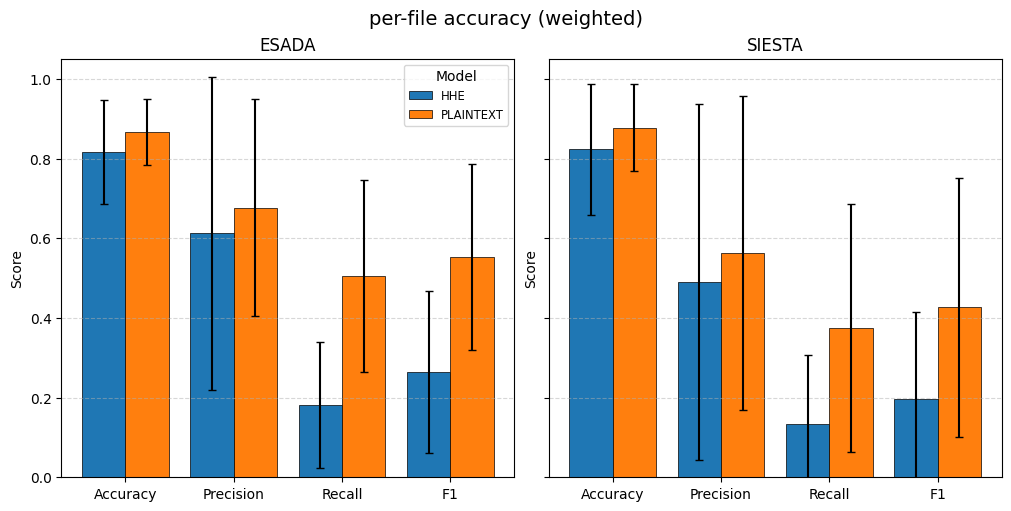

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
#  Plot helper – works for both un‑weighted and weighted summaries
# --------------------------------------------------------------
def plot_summary(df: pd.DataFrame, weighted: bool = False) -> None:
    """
    Grouped bar chart with error bars.

    Parameters
    ----------
    df : pd.DataFrame
        Summary DataFrame produced by ``summary_stats`` (un‑weighted) or
        ``summary_stats_weighted`` (weighted).
    weighted : bool
        If True the function expects columns ending in ``_wmean`` / ``_wstd``.
        If False it expects columns ending in ``_mean`` / ``_std``.
    """
    mean_suffix = "_wmean" if weighted else "_mean"
    std_suffix  = "_wstd"  if weighted else "_std"

    metrics = ["accuracy", "precision", "recall", "f1"]
    metric_labels = ["Accuracy", "Precision", "Recall", "F1"]

    datasets = df["dataset"].unique()
    models   = df["model"].unique()
    n_models = len(models)

    bar_width = 0.8 / n_models

    fig, axes = plt.subplots(
        1,
        len(datasets),
        figsize=(5 * len(datasets), 5),
        sharey=True,
        constrained_layout=True,
    )
    if len(datasets) == 1:
        axes = [axes]

    for ax, ds in zip(axes, datasets):
        sub = df[df["dataset"] == ds]
        ind = np.arange(len(metrics))

        for i, model in enumerate(models):
            mean_cols = [m + mean_suffix for m in metrics]
            std_cols  = [m + std_suffix  for m in metrics]

            means = sub[sub["model"] == model][mean_cols].values.squeeze()
            stds  = sub[sub["model"] == model][std_cols].values.squeeze()

            pos = ind + i * bar_width
            ax.bar(
                pos,
                means,
                width=bar_width,
                yerr=stds,
                capsize=3,
                label=model.split('_')[0].upper(),   # “HHE” or “PLAINTEXT”
                color=("C0" if model == "hhe_binaryoutput" else "C1"),
                edgecolor="black",
                linewidth=0.5,
            )

        ax.set_xticks(ind + bar_width * (n_models - 1) / 2)
        ax.set_xticklabels(metric_labels, rotation=0)
        ax.set_title(ds.upper())
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1.05)
        ax.grid(axis="y", linestyle="--", alpha=0.5)

        if ax is axes[0]:
            ax.legend(title="Model", loc="upper right", fontsize="small")

    title = "per-file accuracy (weighted)" if weighted else "per-file accuracy (unweighted)"
    fig.suptitle(title, fontsize=14)
    plt.show()


plot_summary(summary, weighted=False)
plot_summary(weighted_summary, weighted=True)

In [8]:
def overall_metrics(root_dir: Path, df: pd.DataFrame) -> pd.DataFrame:
    """
    For each (dataset, model) pair concatenate all predictions and the
    ground‑truth, then compute a single set of metrics.
    Returns a DataFrame with columns:
    dataset, model, accuracy, precision, recall, f1, n_samples_total
    """
    overall = []
    for (ds, mdl), sub in df.groupby(["dataset", "model"]):
        preds = []
        trues = []
        for fid in sub["file_id"]:
            pred_path = (
                root_dir
                / f"{ds.upper()}_4percent"
                / mdl
                / f"{fid}_{mdl}.txt"
            )
            gt_path = (
                root_dir
                / f"{ds.upper()}_4percent"
                / "baseline_binaryoutput"
                / f"{fid}_binaryoutput.txt"
            )
            preds.append(read_binary_file(pred_path))
            trues.append(read_binary_file(gt_path))

        y_pred = np.concatenate(preds)
        y_true = np.concatenate(trues)

        overall.append(
            {
                "dataset": ds,
                "model": mdl,
                "accuracy": accuracy_score(y_true, y_pred),
                "precision": precision_score(y_true, y_pred, zero_division=0),
                "recall": recall_score(y_true, y_pred, zero_division=0),
                "f1": f1_score(y_true, y_pred, zero_division=0),
                "n_samples_total": len(y_true),
            }
        )
    return pd.DataFrame(overall)


overall = overall_metrics(ROOT, all_results)
display(overall)

,dataset,model,accuracy,precision,recall,f1,n_samples_total
0,esada,hhe_binaryoutput,0.815689,0.805893,0.228464,0.356004,27383
1,esada,plaintext_binaryoutput,0.866482,0.760476,0.585586,0.661669,27382
2,siesta,hhe_binaryoutput,0.822939,0.877671,0.219055,0.350603,24918
3,siesta,plaintext_binaryoutput,0.877353,0.817044,0.564282,0.667537,24917


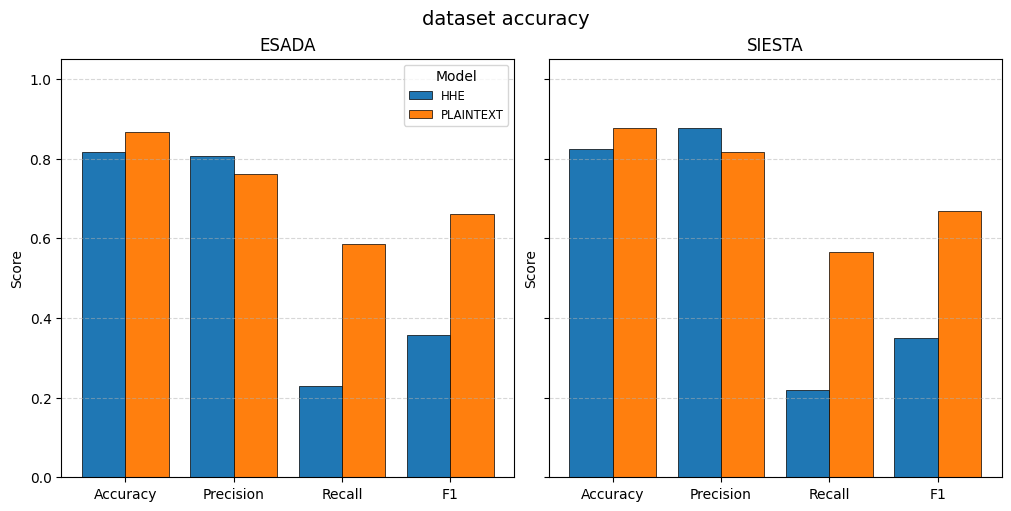

In [10]:
def plot_overall_metrics(df: pd.DataFrame) -> None:
    """
    Grouped bar chart:
        - one subplot per dataset (ESADA, SIESTA)
        - four metrics on the x‑axis (accuracy, precision, recall, f1)
        - two coloured bars per metric – one for each model
    """
    required = {"dataset", "model", "accuracy", "precision", "recall", "f1"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"The DataFrame is missing columns: {missing}")

    metrics = ["accuracy", "precision", "recall", "f1"]
    metric_labels = ["Accuracy", "Precision", "Recall", "F1"]
    models = df["model"].unique()
    n_models = len(models)

    colours = plt.cm.tab10.colors[:n_models]
    bar_width = 0.8 / n_models

    datasets = df["dataset"].unique()
    fig, axes = plt.subplots(
        1,
        len(datasets),
        figsize=(5 * len(datasets), 5),
        sharey=True,
        constrained_layout=True,
    )
    if len(datasets) == 1:
        axes = [axes]

    for ax, ds in zip(axes, datasets):
        sub = df[df["dataset"] == ds]
        ind = np.arange(len(metrics))

        for i, model in enumerate(models):
            vals = sub[sub["model"] == model][metrics].values.squeeze()
            pos = ind + i * bar_width
            ax.bar(
                pos,
                vals,
                width=bar_width,
                label=model.split('_')[0].upper(),   # “HHE” or “PLAINTEXT”
                color=colours[i],
                edgecolor="black",
                linewidth=0.5,
            )

        ax.set_xticks(ind + bar_width * (n_models - 1) / 2)
        ax.set_xticklabels(metric_labels, rotation=0)
        ax.set_title(ds.upper())
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1.05)
        ax.grid(axis="y", linestyle="--", alpha=0.5)

        if ax is axes[0]:
            ax.legend(title="Model", loc="upper right", fontsize="small")

    fig.suptitle(
        "dataset accuracy",
        fontsize=14,
    )
    plt.show()


# 3️⃣ Overall metrics (two models side‑by‑side)
plot_overall_metrics(overall)